In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from datetime import timedelta, datetime
import holidays

In [3]:
df = pd.read_csv('../data.csv')
df.head()

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['wk_strt_dt'] = pd.to_datetime(df['wk_strt_dt'])

In [5]:
# Function to pull Google Search Trends

from pytrends.request import TrendReq

def interest_over_time_df(df, date_column_index, kw_list):
    
    date_column_index_string = df.columns[date_column_index]
    
    pytrends = TrendReq(hl='en-US', tz = 300)
    
    pytrends.build_payload(kw_list, 
                           cat=0, 
                           timeframe=f"{str(df.iloc[0,date_column_index])[0:10]} {str(df.iloc[-1,date_column_index])[0:10]}", 
                           geo='CA', 
                           gprop='')
    
    interest_df = pytrends.interest_over_time()
    interest_df.drop('isPartial', axis=1, inplace = True)
    interest_df.reset_index(inplace = True)
        
    out_df = pd.merge(df, 
                   interest_df.reset_index(), 
                   how = 'left', 
                   left_on=date_column_index_string, 
                   right_on='date')
    
    out_df.drop(['date', 'index'], axis = 1, inplace = True)
    
    return out_df


In [6]:
# Function to pull economic data from Statistics Canada

from stats_can import StatsCan

data_vectors_dict = {'Monthly GDP Growth Rate (Annualised)': 'v65201210', 
                     'Monthly Inflation Rate (Annualised)': 'v41690973', 
                     'Unemployment Rate':'v2062815'}

def append_monthly_unemployment_rate(df, date_row):
    sc = StatsCan()
    econ_df = sc.vectors_to_df_remote('v2062815', periods = 360)
    econ_df.columns = ['unemployment_rate']
    econ_df = econ_df.reset_index()
    
    econ_df['refPer_yr_mth'] = [item for item in zip(econ_df['refPer'].dt.year, econ_df['refPer'].dt.month)]
    
    df['date_row_yr_mth'] = [item for item in zip(df[date_row].dt.year, df[date_row].dt.month)]
    
    df_merge_orig_gdp = pd.merge(df, 
                                econ_df.iloc[:,[-2,-1]], 
                                how = 'left', 
                                left_on='date_row_yr_mth', 
                                right_on='refPer_yr_mth')
    
    return df_merge_orig_gdp


In [7]:
new_df = interest_over_time_df(df, 0, ['Electronics'])

In [8]:
new_df = append_monthly_unemployment_rate(new_df, 'wk_strt_dt')

In [9]:
new_df.drop(['date_row_yr_mth', 'refPer_yr_mth'], axis = 1, inplace = True)

In [10]:
new_df

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48,Electronics,unemployment_rate
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,61,7.0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,66,7.0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,62,7.0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,72,7.0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,63,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,2018,2,5,5,22,13038,13828188,387,2135131,...,0,0,0,0,0,0,0,0,44,5.8
205,2018-07-08,2018,2,6,1,23,0,3714294,0,1448480,...,0,0,0,0,0,0,0,0,48,5.8
206,2018-07-15,2018,2,6,2,24,2225092,5102353,0,1307764,...,0,0,0,0,0,0,0,0,54,5.8
207,2018-07-22,2018,2,6,3,25,17544331,1478566,1891,510539,...,0,0,0,0,0,0,0,0,46,5.8


In [11]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   wk_strt_dt                209 non-null    datetime64[ns]
 1   yr_nbr                    209 non-null    int64         
 2   qtr_nbr                   209 non-null    int64         
 3   prd                       209 non-null    int64         
 4   wk_nbr                    209 non-null    int64         
 5   wk_in_yr_nbr              209 non-null    int64         
 6   mdip_dm                   209 non-null    int64         
 7   mdip_inst                 209 non-null    int64         
 8   mdip_nsp                  209 non-null    int64         
 9   mdip_auddig               209 non-null    int64         
 10  mdip_audtr                209 non-null    int64         
 11  mdip_vidtr                209 non-null    int64         
 12  mdip_viddig           

## Holidays

- Combine Columns 39 - 60 (Holiday Marker)
- Automate designation of holidays

In [12]:
# Install holidays package

# import sys

# !{sys.executable} -m pip install holidays

In [13]:
new_df['is_holiday_week'] = (new_df.iloc[:,range(39,61)].sum(axis = 1) > 0).astype(int)

In [14]:
new_df['is_holiday_week'].value_counts()

0    142
1     67
Name: is_holiday_week, dtype: int64

In [15]:
hldy_seas_cols = [column for column in new_df.columns if ('hldy_' in column) or ('seas_' in column)]
hldy_seas_cols

['hldy_Black Friday',
 'hldy_Christmas Day',
 'hldy_Christmas Eve',
 'hldy_Columbus Day',
 'hldy_Cyber Monday',
 'hldy_Day after Christmas',
 'hldy_Easter',
 "hldy_Father's Day",
 'hldy_Green Monday',
 'hldy_July 4th',
 'hldy_Labor Day',
 'hldy_MLK',
 'hldy_Memorial Day',
 "hldy_Mother's Day",
 'hldy_NYE',
 "hldy_New Year's Day",
 'hldy_Pre Thanksgiving',
 'hldy_Presidents Day',
 'hldy_Prime Day',
 'hldy_Thanksgiving',
 "hldy_Valentine's Day",
 'hldy_Veterans Day',
 'seas_prd_1',
 'seas_prd_2',
 'seas_prd_3',
 'seas_prd_4',
 'seas_prd_5',
 'seas_prd_6',
 'seas_prd_7',
 'seas_prd_8',
 'seas_prd_9',
 'seas_prd_12',
 'seas_week_40',
 'seas_week_41',
 'seas_week_42',
 'seas_week_43',
 'seas_week_44',
 'seas_week_45',
 'seas_week_46',
 'seas_week_47',
 'seas_week_48']

In [16]:
df_no_hldy_seas = new_df.drop(hldy_seas_cols, axis = 1)
df_no_hldy_seas

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3,Electronics,unemployment_rate,is_holiday_week
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,716.285714,0.000000,0.368029,1,0,0,0,61,7.0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,716.428571,0.000000,0.360911,1,0,0,0,66,7.0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,717.000000,0.000000,0.344832,1,1,0,0,62,7.0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,717.000000,0.000000,0.356973,1,1,0,0,72,7.0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,717.000000,0.000000,0.359990,0,1,0,0,63,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,2018,2,5,5,22,13038,13828188,387,2135131,...,599.000000,0.415964,0.371423,0,1,0,0,44,5.8,1
205,2018-07-08,2018,2,6,1,23,0,3714294,0,1448480,...,599.000000,0.457615,0.372676,0,1,1,0,48,5.8,1
206,2018-07-15,2018,2,6,2,24,2225092,5102353,0,1307764,...,599.000000,0.382469,0.363597,0,0,1,0,54,5.8,0
207,2018-07-22,2018,2,6,3,25,17544331,1478566,1891,510539,...,599.000000,0.272084,0.360448,0,1,0,0,46,5.8,0


In [17]:
df_no_hldy_seas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 0 to 208
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   wk_strt_dt         209 non-null    datetime64[ns]
 1   yr_nbr             209 non-null    int64         
 2   qtr_nbr            209 non-null    int64         
 3   prd                209 non-null    int64         
 4   wk_nbr             209 non-null    int64         
 5   wk_in_yr_nbr       209 non-null    int64         
 6   mdip_dm            209 non-null    int64         
 7   mdip_inst          209 non-null    int64         
 8   mdip_nsp           209 non-null    int64         
 9   mdip_auddig        209 non-null    int64         
 10  mdip_audtr         209 non-null    int64         
 11  mdip_vidtr         209 non-null    int64         
 12  mdip_viddig        209 non-null    int64         
 13  mdip_so            209 non-null    int64         
 14  mdip_on   

## Baseline Model - Vanilla ARIMA on `sales` column

In [18]:
df_no_hldy_seas.set_index('wk_strt_dt', inplace = True)

In [19]:
df_no_hldy_seas.head()

,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,mdip_audtr,...,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3,Electronics,unemployment_rate,is_holiday_week
wk_strt_dt,,,,,,,,,,,,,,,,,,,,,
2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,37778097,...,716.285714,0.0,0.368029,1,0,0,0,61,7.0,0
2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,12063657,...,716.428571,0.0,0.360911,1,0,0,0,66,7.0,0
2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,5770115,...,717.000000,0.0,0.344832,1,1,0,0,62,7.0,0
2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,12174000,...,717.000000,0.0,0.356973,1,1,0,0,72,7.0,0
2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,31656134,...,717.000000,0.0,0.359990,0,1,0,0,63,7.0,1


Text(0.5, 1.0, 'Weekly Sales (Units)')

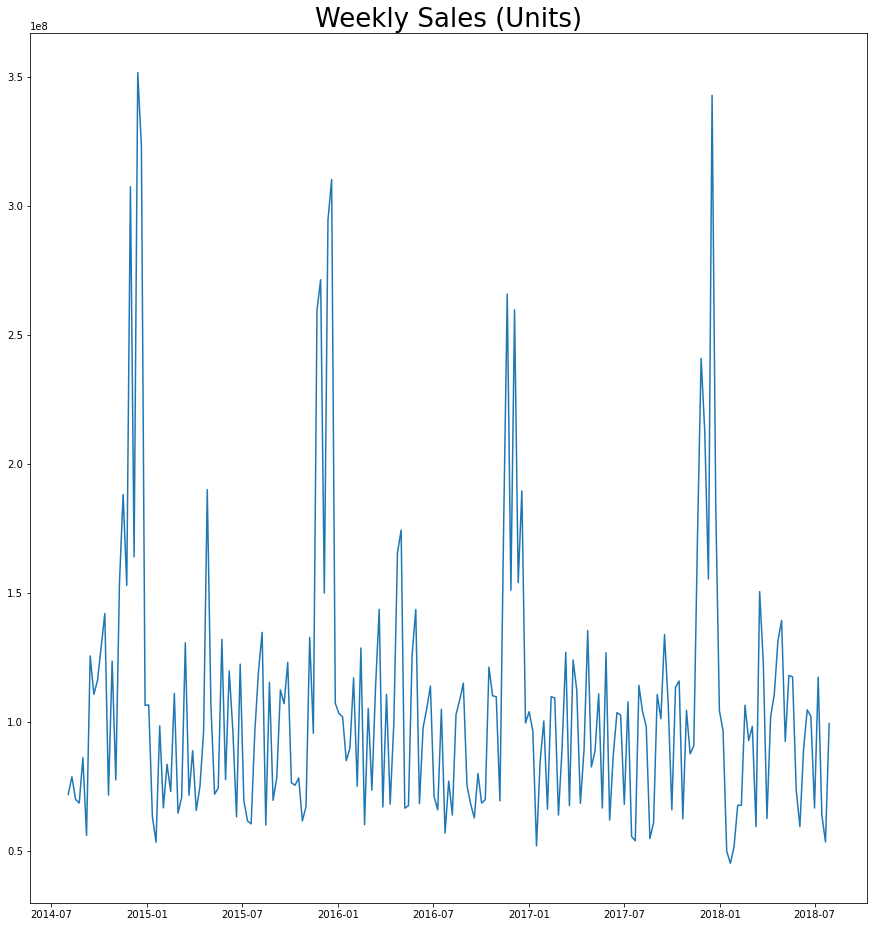

In [20]:
plt.figure(figsize = (15, 16))
plt.plot(df_no_hldy_seas['sales'])

plt.title('Weekly Sales (Units)', fontsize=26)

In [21]:
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
# Import Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

In [23]:
adfuller(df_no_hldy_seas['sales'])

# p-value is very low, so `sales` is likely stationary

(-5.937058849863105,
 2.307578482014885e-07,
 5,
 203,
 {'1%': -3.462980134086401,
  '5%': -2.875885461947131,
  '10%': -2.5744164898444515},
 7372.235215759946)

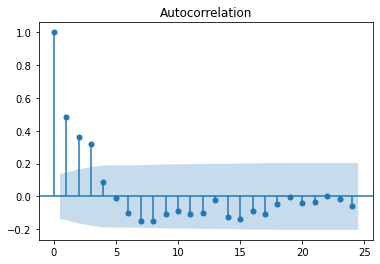

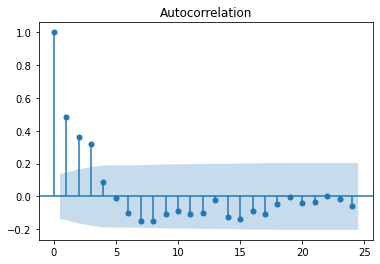

In [24]:
plot_acf(df_no_hldy_seas['sales'])

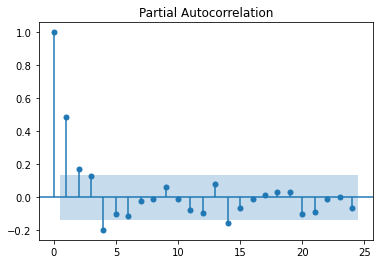

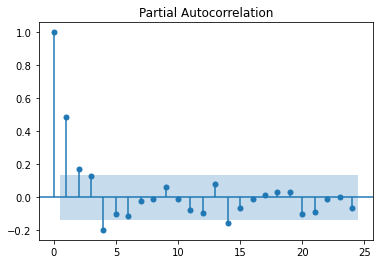

In [25]:
plot_pacf(df_no_hldy_seas['sales'])

Sharp cutoff around $p = 4$, so that is a good candidate for parameter $p$ in the `ARIMA(p, d, q)` model

In [26]:
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(df_no_hldy_seas.drop(['sales'], axis=1),
                                                    df_no_hldy_seas['sales'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

In [27]:
y_test.index

DatetimeIndex(['2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11',
               '2017-06-18', '2017-06-25', '2017-07-02', '2017-07-09',
               '2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06',
               '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03',
               '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
               '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
               '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26',
               '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24',
               '2017-12-31', '2018-01-07', '2018-01-14', '2018-01-21',
               '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
               '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18',
               '2018-03-25', '2018-04-01', '2018-04-08', '2018-04-15',
               '2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13',
               '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10',
      

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (2,0,0)) # (p, d, q) <-- talk about q later!

C:\Users\gabri\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\gabri\.conda\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred

In [30]:
arima_4_0_0 = model.fit()

In [31]:
np.datetime64(y_test.index[0]).astype(datetime)

datetime.datetime(2017, 5, 21, 0, 0)

In [32]:
# Generate predictions.
preds = model.predict(params=arima_4_0_0.params,
                      start=np.datetime64(y_test.index[0]).astype(datetime),
                      end=np.datetime64(y_test.index[-1]).astype(datetime))

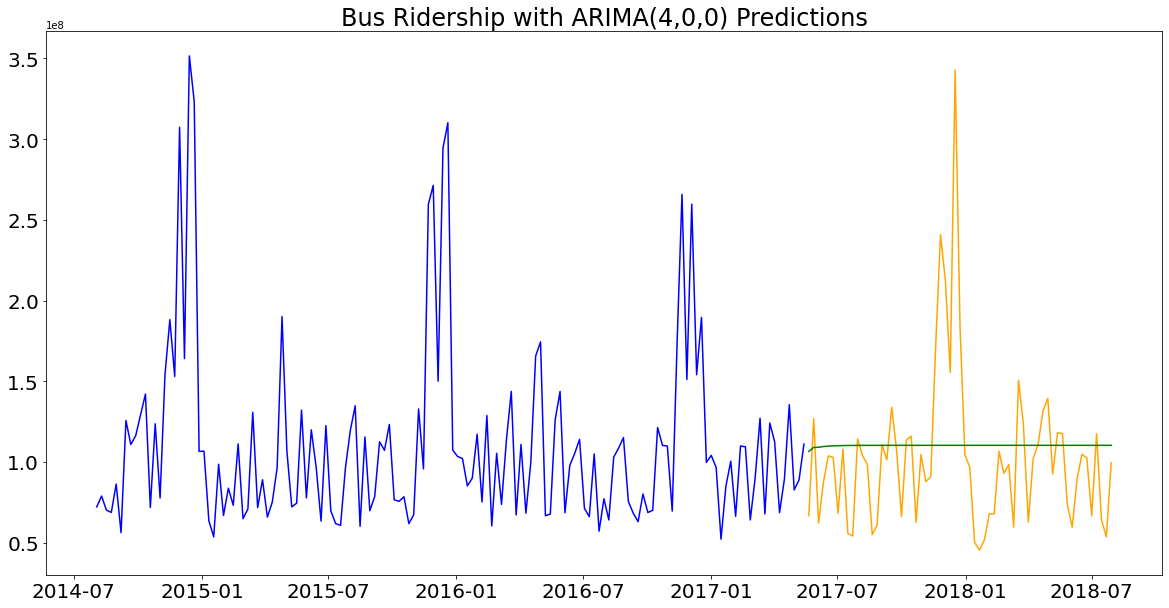

In [33]:
# Plot data.

# Set figure size.
plt.figure(figsize=(20,10))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

# Set label.
plt.title(label = 'Bus Ridership with ARIMA(4,0,0) Predictions', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);